# PRECISION RECALL CURVE

In this jupyter notebook we will analyze the performance of classifiers trained with data having unbalanced classes, utilizing precision recall curves. We will also learn how to save and load sklearn models using the python package pickle.

**Add the directory of the m_learn package to the system path**

In [1]:
from config import *
append_path('../../')

**Import neccessary packages and modules**

In [2]:
import pandas as pd
import numpy as np
np.random.seed(1)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
from m_learn.utility.data_preprocessing import train_test_feature_scaler
import matplotlib.pyplot as plt
import matplotlib

## 1. Load and preprocess data

### 1.1 Load and view the credit card data

In [3]:
data = pd.read_csv('../data/credit_card_fraud_detection/creditcard.csv')

In [4]:
data.head(10)

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5   2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
6   4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708 -0.005159   
7   7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
8   7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   
9   9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   
5  0.260314 -0.568671  ...   -0.208254 -0.559825 -0.026398 -0.371427   
6  0.081213  0.464960  ...   -0.167716 -0.270710 -0.154104 -0.780055   
7 -3.807864  0.615375  ...    1.943465 -1.015455  0.057504 -0.649709   
8  0.851084 -0.392048  ...   -0.073425 -0.268092 -0.204233  1.011592   
9  0.069539 -0.736727  ...   -0.246914 -0.633753 -0.120794 -0.385050   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  
3  0.647376 -0.221929  0.062723  0.061458  123.50      0  
4 -0.206010  0.502292  0.219422  0.215153   69.99      0  
5 -0.232794  0.105915  0.253844  0.081080    3.67      0  
6  0.750137 -0.257237  0.034507  0.005168    4.99      0  
7 -0.415267 -0.051634 -1.206921 -1.085339   40.80      0  
8  0.373205 -0.384157  0.011747  0.142404   93.20      0  
9 -0.069733  0.094199  0.246219  0.083076    3.68      0  

[10 rows x 31 columns]

In [5]:
print("Shape of data:", data.shape)

Shape of data: (284807, 31)


Drop the "Time" column

In [6]:
data = data.drop("Time", axis=1)

**Inspect the number of positive examples in the data**

In [7]:
num_positve_examples = data[data['Class']== 1].shape[0]
print("Number of positive examples:",num_positve_examples)

Number of positive examples: 492


### 1.2 Undersample the negative examples 

**Extract all the positive examples**

In [8]:
positve_examples = data[data['Class']== 1]
positve_examples['Class'][:10]

541     1
623     1
4920    1
6108    1
6329    1
6331    1
6334    1
6336    1
6338    1
6427    1
Name: Class, dtype: int64

**Undersample the negative examples i.e. select a smaller negative sample from the entire dataset**

In [9]:
# extract all the negative examples
negative_indices = data[data['Class'] == 0].index
# randomly choose the indices of the undersampled negative examples
random_indices = np.random.choice(negative_indices, num_positve_examples*3, replace=False)
# extract the undersampled points from negative examples
negative_examples = data.loc[random_indices]
# display the negative examples
negative_examples['Class'].head(10)

106066    0
102005    0
278450    0
120218    0
258527    0
179643    0
164566    0
66593     0
116962    0
237239    0
Name: Class, dtype: int64

In [10]:
negative_examples.shape

(1476, 30)

**Append the positve examples to the undersampled negative examples**

In [11]:
undersampled_data = negative_examples.append(positve_examples)

**Train test split the data**

In [12]:
train_data, test_data = train_test_split(undersampled_data, test_size = 0.20, random_state = 0)

**Inspect the number of positve & negative examples in test data**

In [13]:
print("No.of positive examples in test data:", test_data[test_data['Class']== 1].shape[0])
print("No.of negative examples in test data:", test_data[test_data['Class']== 0].shape[0])

No.of positive examples in test data: 98
No.of negative examples in test data: 296


## 2. Train logistic regression models having different C values and save the models

**Features and output of the models**

In [14]:
features = data.columns.tolist()
output = "Class"
features.remove(output)

**Feature scale the train and test data**

In [15]:
# import the minmax scaler module from scikit learn
from sklearn.preprocessing import MinMaxScaler
# create a scalar object that scales data into a range of -1 to 1
scaler = MinMaxScaler((-1,1))
# scale the train and test set using the specialized scaling function
train_data, test_data = train_test_feature_scaler(scaler, train_data, test_data, features)

**List of C values**

In [16]:
range_1 = np.linspace(0.001,0.1, num = 15)
range_2 = np.linspace(0.1,4000, num = 16)
range_2 = np.delete(range_2, 0)
C_values = np.concatenate((range_1, range_2), axis = 0)
print("C values:", C_values)

C values: [1.00000000e-03 8.07142857e-03 1.51428571e-02 2.22142857e-02
 2.92857143e-02 3.63571429e-02 4.34285714e-02 5.05000000e-02
 5.75714286e-02 6.46428571e-02 7.17142857e-02 7.87857143e-02
 8.58571429e-02 9.29285714e-02 1.00000000e-01 2.66760000e+02
 5.33420000e+02 8.00080000e+02 1.06674000e+03 1.33340000e+03
 1.60006000e+03 1.86672000e+03 2.13338000e+03 2.40004000e+03
 2.66670000e+03 2.93336000e+03 3.20002000e+03 3.46668000e+03
 3.73334000e+03 4.00000000e+03]


**Train and save the logistic regression models having different C values**

In [17]:
# import the python pickle package
import pickle
# iterate through each C value
for n, C in enumerate(C_values):    
    # create and train model with the given C value
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(train_data[features], train_data[output])
    # save the model in the designated directory
    pickle.dump(model, open("./fraud_detection_models/model_"+str(n)+".mdl", 'wb'))
    # print statement
    print("Completed training of model with C value: {0:0.5f}".format(C))

Completed training of model with C value: 0.00100
Completed training of model with C value: 0.00807
Completed training of model with C value: 0.01514
Completed training of model with C value: 0.02221
Completed training of model with C value: 0.02929
Completed training of model with C value: 0.03636
Completed training of model with C value: 0.04343
Completed training of model with C value: 0.05050
Completed training of model with C value: 0.05757
Completed training of model with C value: 0.06464
Completed training of model with C value: 0.07171
Completed training of model with C value: 0.07879
Completed training of model with C value: 0.08586
Completed training of model with C value: 0.09293
Completed training of model with C value: 0.10000
Completed training of model with C value: 266.76000
Completed training of model with C value: 533.42000
Completed training of model with C value: 800.08000
Completed training of model with C value: 1066.74000
Completed training of model with C value:

## 3. Load the saved models and access their performance based on various metrics

**Lists to store the performance metrics of the models**

In [18]:
accuracy_scores = []
precison_scores = []
recall_scores = []

**Load and evaluate the performance metrics of all the models using test data**

In [19]:
# a list to store the saved models
models = []
# iterate through the models
for n in range(len(C_values)):
    # filename of the model
    filename = "./fraud_detection_models/model_"+str(n)+".mdl"
    # load the saved model
    model = pickle.load(open(filename, 'rb'))
    # append the model to the designated list
    models.append(model)
    # append the performance metrics to the designated lists
    accuracy_scores.append(accuracy_score(test_data[output], model.predict(test_data[features])))
    precison_scores.append(precision_score(test_data[output], model.predict(test_data[features])))
    recall_scores.append(recall_score(test_data[output], model.predict(test_data[features])))

**Tabulate the results in a pandas dataframe**

In [20]:
performance_table = pd.DataFrame({"C":C_values, "Accuracy":accuracy_scores,\
                                   "Precision":precison_scores, "Recall":recall_scores})
performance_table[["C","Accuracy","Precision","Recall"]]

C  Accuracy  Precision    Recall
0      0.001000  0.804569   1.000000  0.214286
1      0.008071  0.868020   1.000000  0.469388
2      0.015143  0.885787   1.000000  0.540816
3      0.022214  0.893401   1.000000  0.571429
4      0.029286  0.903553   1.000000  0.612245
5      0.036357  0.913706   1.000000  0.653061
6      0.043429  0.921320   1.000000  0.683673
7      0.050500  0.926396   1.000000  0.704082
8      0.057571  0.934010   1.000000  0.734694
9      0.064643  0.934010   1.000000  0.734694
10     0.071714  0.934010   1.000000  0.734694
11     0.078786  0.934010   1.000000  0.734694
12     0.085857  0.934010   1.000000  0.734694
13     0.092929  0.936548   1.000000  0.744898
14     0.100000  0.939086   1.000000  0.755102
15   266.760000  0.956853   0.955056  0.867347
16   533.420000  0.956853   0.955056  0.867347
17   800.080000  0.956853   0.955056  0.867347
18  1066.740000  0.956853   0.955056  0.867347
19  1333.400000  0.956853   0.955056  0.867347
20  1600.060000  0.956853   0.955056  0.867347
21  1866.720000  0.956853   0.955056  0.867347
22  2133.380000  0.956853   0.955056  0.867347
23  2400.040000  0.956853   0.955056  0.867347
24  2666.700000  0.956853   0.955056  0.867347
25  2933.360000  0.959391   0.965909  0.867347
26  3200.020000  0.959391   0.965909  0.867347
27  3466.680000  0.959391   0.965909  0.867347
28  3733.340000  0.959391   0.965909  0.867347
29  4000.000000  0.959391   0.965909  0.867347

**Plot the results**

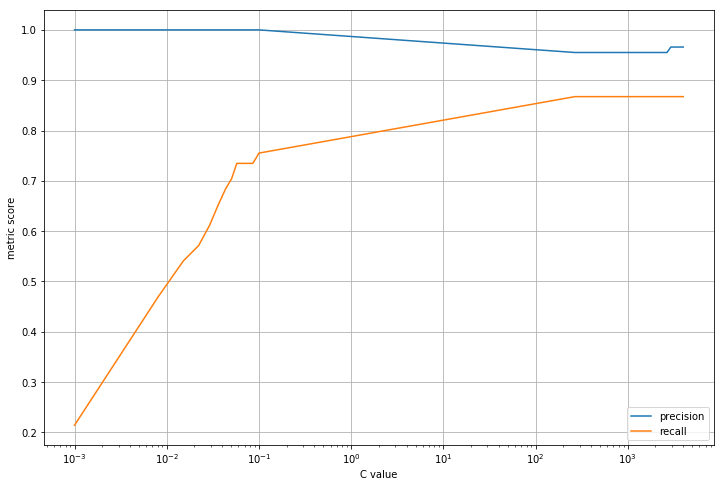

In [21]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.plot(performance_table.C, performance_table.Precision, label = "precision")
plt.plot(performance_table.C, performance_table.Recall, label = "recall")
plt.xscale('log')
plt.xlabel("C value")
plt.ylabel("metric score")
plt.legend()
plt.grid()
plt.show()

## 4. Investigate the performance of few models using precision recall curve

### 4.1 A function which creates  confusion matrix and stores it in a pandas dataframe

In [22]:
def confusion_matrix_(fitted_model, test_data, features, output, numeric_labels, classes):
    
    '''
    A function which creates the confusion matrix in pandas dataframe
    
    Arguments:
    fitted_model - object of the fitted sklearn classifier model
    test_data - a pandas dataframe containing test data
    features - a list containing the features of the model
    output - output of the model
    numeric_labels - a list of numeric labels of the model(usually 1 and 0)
    classes - corresponding list of classes/string labels (usually 'positive' and 'negetive'),
              we uses this to name the index and column of pandas df
    Returns:
    matrix - a pandas dataframe containing the confusion matrix
    '''
    # import pandas and confusion_matrix from sklearn
    import pandas as pd
    from sklearn.metrics import confusion_matrix
     
    # Create a confusion matrix using the sklearn function
    # labels are given to control the order of the class in confusion matrix
    # e.g. +1 is the first column and 0 is the second column in this case
    output_column = test_data[output]
    predictions = fitted_model.predict(test_data[features])    
    matrix = confusion_matrix(output_column, predictions, labels = numeric_labels)
    # convert the numpy array to pandas dataframe with named indexes and columns
    matrix = pd.DataFrame(matrix, columns=classes, index=classes)
    # return the matrix
    return matrix  

### 4.2 Investigate model 29

**Display the confusion matrix of model 29**

In [23]:
model = models[29]
Confusion_matrix = confusion_matrix_(model, test_data, features, output, numeric_labels=[1,0], classes=["positive","negative"])
Confusion_matrix

positive  negative
positive        85        13
negative         3       293

**Extract the precision & recall data**

In [24]:
# extract the y score
y_score = model.decision_function(test_data[features])
# compute the precision recall data
precision, recall, _ = precision_recall_curve(test_data[output], y_score)

**Precision recall curve**

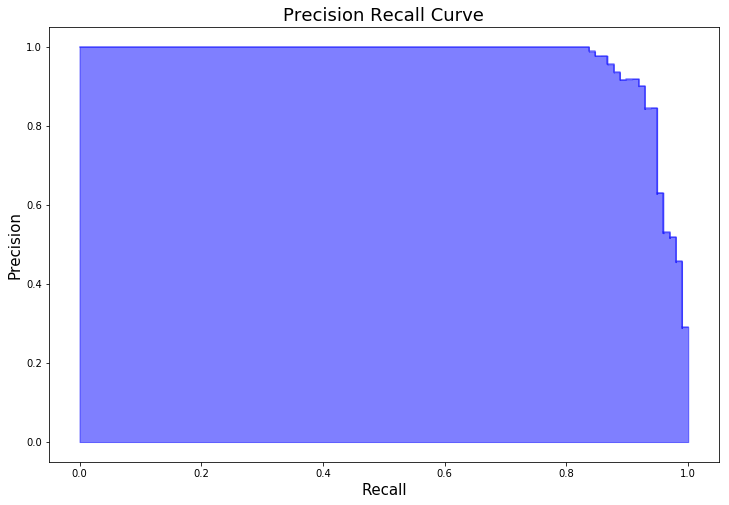

In [25]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.step(recall, precision, color='b', alpha=0.5,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='b')
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.title("Precision Recall Curve", fontsize = 18)
plt.show()

In [26]:
print("Area under the precision recall curve: ",np.trapz(recall, precision, axis = 0))

Area under the precision recall curve:  0.6744480653830718


### 4.3 A visualization function to plot the precision recall curve

In [27]:
def precision_recall_curve_(fitted_model, test_data, features, ouput):
    
    '''
    A function to plot precision recall curve
    
    Arguments:
    fitted_model - object of sklearn classifier model
    test_data - pandas dataframe containing the test data
    features - a list containing the features of the model
    output - output of the model
    
    Returns:
    precision - list of precision values
    recall - list of recall values
    '''
    
    # import the precision_recall_curve function from sklearn
    from sklearn.metrics import precision_recall_curve
    
    # extract precision recall data
    y_score = fitted_model.decision_function(test_data[features])
    precision, recall, _ = precision_recall_curve(test_data[output], y_score)
    
    # plot the precision recall curve 
    plt.step(recall, precision, color='b', alpha=0.5,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.5, color='b')
    plt.xlabel('Recall', fontsize = 15)
    plt.ylabel('Precision', fontsize = 15)
    plt.title("Precision Recall Curve", fontsize = 18)
    plt.show()
    
    # return the precision recall values
    return precision, recall

### 4.4 Investigate model 4

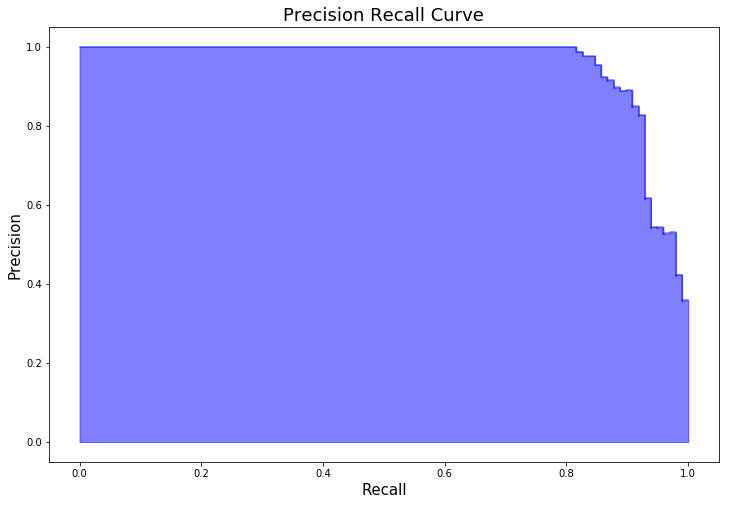

positive  negative
positive        60        38
negative         0       296

In [28]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
model = models[4]
precision, recall = precision_recall_curve_(model, test_data, features, output)
confusion_matrix_(model, test_data, features, output, numeric_labels = [1,0], classes = ["positive","negative"])

In [29]:
print("Area under the precision recall curve: ",np.trapz(recall, precision, axis = 0))

Area under the precision recall curve:  0.5963075954438982


### 4.5 Investigate model 0

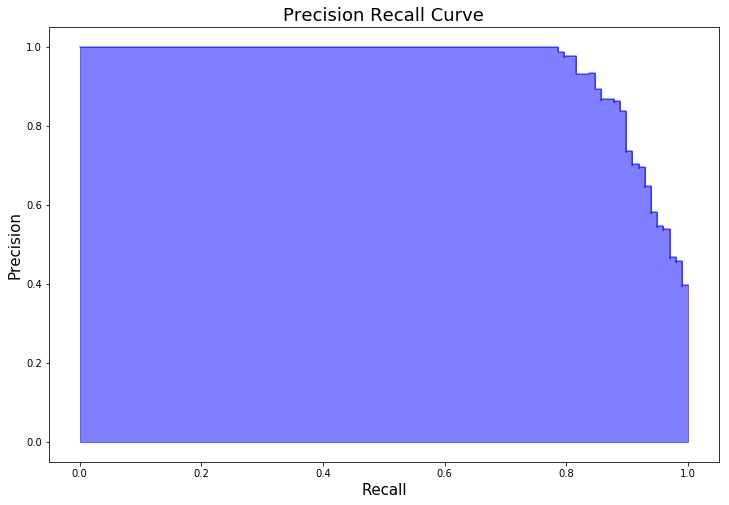

positive  negative
positive        21        77
negative         0       296

In [30]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
model = models[0]
precision, recall = precision_recall_curve_(model, test_data, features, output)
confusion_matrix_(model, test_data, features, output, numeric_labels = [1,0], classes = ["positive","negative"])

In [31]:
print("Area under the precision recall curve: ",np.trapz(recall, precision, axis = 0))

Area under the precision recall curve:  0.5503485132510421
